# Implementing a Neural Network

*from Stanford CS231n assignment 2*

In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
from itertools import product
import pickle

The neural network parameters will be stored in a dictionary (`model` below), where the keys are the parameter names and the values are numpy arrays. Below, we initialize toy data and a toy model that we will use to verify your implementations.

In [3]:
# Create some toy data to check your implementations
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    model = {}
    model['W1'] = np.linspace(-0.2, 0.6, num=input_size*hidden_size).reshape(input_size, hidden_size)
    model['b1'] = np.linspace(-0.3, 0.7, num=hidden_size)
    model['W2'] = np.linspace(-0.4, 0.1, num=hidden_size*num_classes).reshape(hidden_size, num_classes)
    model['b2'] = np.linspace(-0.5, 0.9, num=num_classes)
    return model

def init_toy_data():
    X = np.linspace(-0.2, 0.5, num=num_inputs*input_size).reshape(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

model = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the function `two_layer_net`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [4]:
def two_layer_net(X, model, y=None, reg=0.0):
    """Compute the loss and gradients for a two layer fully connected NN.

    The net has an input dimension of D, a hidden layer dimension of H,
    and performs classification over C classes. We use a softmax loss function
    and L2 regularization the the weight matrices. The two layer net should
    use a ReLU nonlinearity after the first affine layer.

    The two layer net has the following architecture:

        input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each
    class.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - model: Dictionary mapping parameter names to arrays of parameter values.
      It should contain the following:
      - W1: First layer weights; has shape (D, H)
      - b1: First layer biases; has shape (H,)
      - W2: Second layer weights; has shape (H, C)
      - b2: Second layer biases; has shape (C,)
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i]
      is an integer in the range 0 <= y[i] < C. This parameter is optional;
      if it is not passed then we only return scores, and if it is passed then
      we instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is not passed, return a matrix scores of shape (N, C) where
    scores[i, c] is the score for class c on input X[i].

    If y is passed, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those
      parameters with respect to the loss function. This should have the same
      keys as model.
    """

    # unpack variables from the model dictionary
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    N, D = X.shape

    # compute the forward pass
    scores = None   # shape (N, C)

    # Layer 1
    # ReLU forward implementation
    # Ref: http://cs231n.github.io/neural-networks-1/
    s1 = X.dot(W1) + b1  # shape (N, H)
    resp1 = np.where(s1 > 0, s1, 0)  # shape (N, H)

    # Layer 2
    s2 = resp1.dot(W2) + b2  # shape (N, C)
    scores = s2

    # If the targets are not given then jump out, we're done
    if y is None:
        return scores

    # compute the loss
    loss = None
    f = scores.T - np.max(scores, axis=1)  # shape (C, N)
    f = np.exp(f)
    p = f / np.sum(f, axis=0)  # shape (C, N)

    # loss function
    _sample_ix = np.arange(N)
    loss = np.mean(-np.log(p[y, _sample_ix]))
    loss += (0.5 * reg) * np.sum(W1 * W1)
    loss += (0.5 * reg) * np.sum(W2 * W2)

    # compute the gradients
    grads = {}

    df = p  # (C, N)
    df[y, _sample_ix] -= 1
    # (H, C) = ((C, N) x (N, H)).T
    dW2 = df.dot(resp1).T / N  # (H, C)
    dW2 += reg * W2
    grads['W2'] = dW2

    # C = (C, N)
    db2 = np.mean(df, axis=1)  # C
    grads['b2'] = db2

    # (N, H) =  (H, C)
    dresp1 = W2.dot(df).T / N
    ds1 = np.where(s1 > 0, dresp1, 0)  # (N, H)
    dW1 = X.T.dot(ds1)  # (D, H)
    dW1 += reg * W1
    grads['W1'] = dW1

    db1 = np.sum(ds1, axis=0)  # H
    grads['b1'] = db1
    return loss, grads

In [5]:
scores = two_layer_net(X, model)
print(scores)
correct_scores = [[-0.5328368, 0.20031504, 0.93346689],
 [-0.59412164, 0.15498488, 0.9040914 ],
 [-0.67658362, 0.08978957, 0.85616275],
 [-0.77092643, 0.01339997, 0.79772637],
 [-0.89110401, -0.08754544, 0.71601312]]

# the difference should be very small. We get 3e-8
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

[[-0.5328368   0.20031504  0.93346689]
 [-0.59412164  0.15498488  0.9040914 ]
 [-0.67658362  0.08978957  0.85616275]
 [-0.77092643  0.01339997  0.79772637]
 [-0.89110401 -0.08754544  0.71601312]]
Difference between your scores and correct scores:
3.84868230029e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [6]:
reg = 0.1
loss, _ = two_layer_net(X, model, y, reg)
print(loss)
correct_loss = 1.38191946092

# should be very small, we get 5e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

1.38191946092
Difference between your loss and correct loss:
4.67692551354e-12


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [7]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = two_layer_net(X, model, y, reg)

# these should all be less than 1e-8 or so
for param_name in grads:
    param_grad_num = eval_numerical_gradient(
        lambda W: two_layer_net(X, model, y, reg)[0],
        model[param_name], 
        verbose=False
    )
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b1 max relative error: 2.027454e-08
W2 max relative error: 3.379922e-09
W1 max relative error: 4.426512e-09
b2 max relative error: 2.720082e-11


# Train the network
To train the network we will use SGD with Momentum. Last assignment you implemented vanilla SGD. You will now implement the momentum update and the RMSProp update. Open the file `classifier_trainer.py` and familiarze yourself with the `ClassifierTrainer` class. It performs optimization given an arbitrary cost function data, and model. By default it uses vanilla SGD, which we have already implemented for you. First, run the optimization below using Vanilla SGD:

In [8]:
from cs231n.classifier_trainer import ClassifierTrainer

model = init_toy_model()
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.0, learning_rate_decay=1,
                                             update='sgd', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
print('Final loss with vanilla SGD: %f' % (loss_history[-1], ))

starting iteration  0
starting iteration  50
Final loss with vanilla SGD: 0.940686


Now fill in the **momentum update** in the first missing code block inside the `train` function, and run the same optimization as above but with the momentum update. You should see a much better result in the final obtained loss:

In [9]:
model = init_toy_model()
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='momentum', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.494394
print('Final loss with momentum SGD: %f. We get: %f' % (loss_history[-1], correct_loss))

starting iteration  0
starting iteration  50
Final loss with momentum SGD: 0.494394. We get: 0.494394


Now also implement the **RMSProp** update rule inside the `train` function and rerun the optimization:

In [10]:
model = init_toy_model()
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='rmsprop', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.439368
print('Final loss with RMSProp: %f. We get: %f' % (loss_history[-1], correct_loss))

starting iteration  0
starting iteration  50
Final loss with RMSProp: 0.439368. We get: 0.439368


# Load the data
Now that you have implemented a two-layer network that passes gradient checks, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier.

In [11]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [12]:
from IPython.html import widgets
from IPython.display import display as ipydisplay
from cs231n.vis_utils import ParametersInspectorWindow

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [13]:
def init_two_layer_model(input_size, hidden_size, output_size):
    """Initialize the weights and biases for a two-layer fully connected
    neural network.

    The net has an input dimension of D, a hidden layer dimension of H, and
    performs classification over C classes. Weights are initialized to small
    random values and biases are initialized to zero.

    Inputs:
    - input_size: The dimension D of the input data
    - hidden_size: The number of neurons H in the hidden layer
    - ouput_size: The number of classes C

    Returns:
    A dictionary mapping parameter names to arrays of parameter values.
    It has the following keys:
        - W1: First layer weights; has shape (D, H)
        - b1: First layer biases; has shape (H,)
        - W2: Second layer weights; has shape (H, C)
        - b2: Second layer biases; has shape (C,)
    """
    # initialize a model
    model = {}
    model['W1'] = 0.00001 * np.random.randn(input_size, hidden_size)
    model['b1'] = np.zeros(hidden_size)
    model['W2'] = 0.00001 * np.random.randn(hidden_size, output_size)
    model['b2'] = np.zeros(output_size)
    return model

In [14]:
w = widgets.IntProgress()
ipydisplay(w)

model = init_two_layer_model(32*32*3, 50, 10) # input size, hidden size, number of classes
trainer = ClassifierTrainer()
best_model, loss_history, train_acc, val_acc = trainer.train(
    X_train, y_train, X_val, y_val,
    model, two_layer_net,
    # parameters to be tuned
    num_epochs=7, reg=1,
    momentum=0.9, learning_rate_decay = 0.95,
    learning_rate=2.5e-5, 
    # end of parameters
    progress_bar=w, verbose=True
)

Finished epoch 0 / 7: cost 2.302593, train: 0.081000, val 0.074000, lr 2.500000e-05
Finished epoch 1 / 7: cost 2.162595, train: 0.254000, val 0.252000, lr 2.375000e-05
Finished epoch 2 / 7: cost 1.686903, train: 0.351000, val 0.367000, lr 2.256250e-05
Finished epoch 3 / 7: cost 1.676655, train: 0.395000, val 0.406000, lr 2.143437e-05
Finished epoch 4 / 7: cost 1.785325, train: 0.432000, val 0.421000, lr 2.036266e-05
Finished epoch 5 / 7: cost 1.563465, train: 0.417000, val 0.446000, lr 1.934452e-05
Finished epoch 6 / 7: cost 1.566707, train: 0.464000, val 0.455000, lr 1.837730e-05
Finished epoch 7 / 7: cost 1.510311, train: 0.475000, val 0.446000, lr 1.745843e-05
finished optimization. best validation accuracy: 0.455000


In [15]:
train_acc, val_acc

([0.081000000000000003,
  0.254,
  0.35099999999999998,
  0.39500000000000002,
  0.432,
  0.41699999999999998,
  0.46400000000000002,
  0.47499999999999998],
 [0.073999999999999996,
  0.252,
  0.36699999999999999,
  0.40600000000000003,
  0.42099999999999999,
  0.44600000000000001,
  0.45500000000000002,
  0.44600000000000001])

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.37 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

In [16]:
# Plot the loss function and train / validation accuracies
def vis_history(loss_history, train_acc, val_acc):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(loss_history)
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    return fig

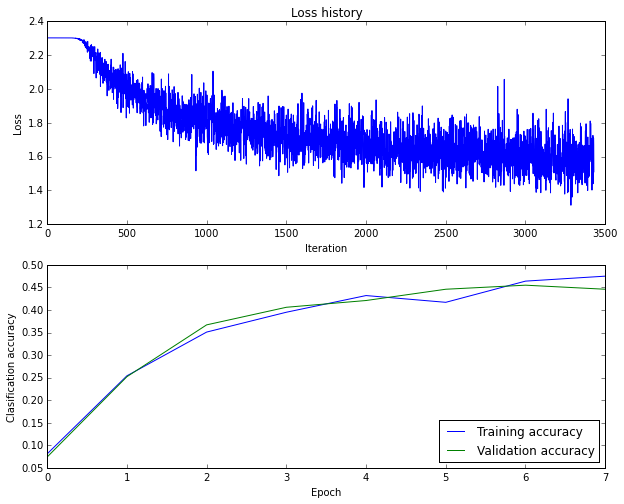

In [17]:
fig = vis_history(loss_history, train_acc, val_acc)

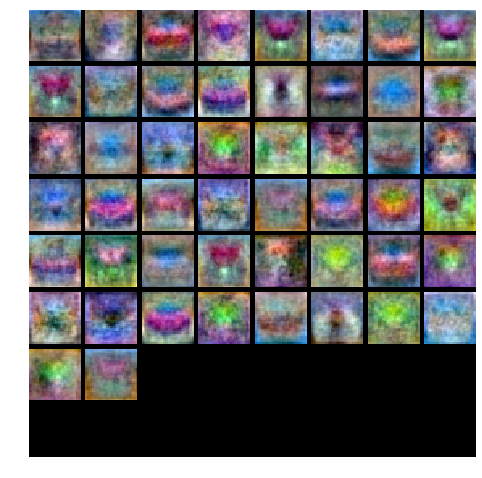

In [18]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(model):
    plt.imshow(visualize_grid(model['W1'].T.reshape(-1, 32, 32, 3), padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(best_model)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set. 

**We will give you extra bonus point for every 1% of accuracy above 56%.**

In [19]:
scores_test = two_layer_net(X_test, best_model)
print('Test accuracy: ', np.mean(np.argmax(scores_test, axis=1) == y_test))

Test accuracy:  0.45
